In [17]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [18]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"

# tags = ['2024-04-12-15-31-26']
# filters = {"tags": {"$in": tags}}
tags = ["2024-05-04-14-15-34"]
filters = {"tags": {"$in": tags}, "state": "finished"}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [19]:
data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

# filter out runs with Evaluation/Mean_Returns == -100
df = df[df['Evaluation/Mean_Returns'] != -100]

ncols, nrows = df["ncols"][0], 4
df

100%|██████████| 6/6 [00:00<00:00, 33156.55it/s]


,_runtime,Evaluation/Discounted_Returns,Evaluation/Mean_Entropy,trajectories,Evaluation/Entropies,_step,_timestamp,Evaluation/Mean_Discounted_Returns,_wandb,Evaluation/Mean_Returns,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,15.670855,"{'_type': 'histogram', 'bins': [0.002218527719...",0.608895,"[[0, 1, 2, 6, 10, 14], [0, 1, 2, 3, 3, 3, 3, 3...","{'bins': [0.4854830801486969, 0.48981028795242...",0,1.714825e+09,0.433543,{'runtime': 14},1.00,...,0.3,4,identity,coordinate,0.000001,PolicyUCT,6,mvc,15,identity
1,33.442800,"{'_type': 'histogram', 'values': [37, 7, 4, 2,...",0.736342,"[[0, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","{'_type': 'histogram', 'bins': [0.542375981807...",0,1.714825e+09,0.190773,{'runtime': 32},0.81,...,0.3,4,identity,coordinate,0.000001,UCT,6,mvc,15,identity
2,42.314417,"{'_type': 'histogram', 'bins': [0, 0.006726048...",0.943807,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 2,...","{'_type': 'histogram', 'bins': [0.899691700935...",0,1.714825e+09,0.022630,{'runtime': 41},0.25,...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
3,11.132610,"{'_type': 'histogram', 'values': [4, 0, 2, 1, ...",0.555893,"[[0, 1, 0, 0, 1, 2, 2, 3, 2, 6, 10, 14], [0, 4...","{'_type': 'histogram', 'bins': [0.406407684087...",0,1.714825e+09,0.394332,{'runtime': 9},1.00,...,0.3,4,identity,coordinate,0.000001,PolicyUCT,6,mvc,15,identity
4,10.113873,"{'values': [3, 3, 1, 0, 3, 3, 2, 3, 1, 3, 1, 2...",0.613829,"[[0, 4, 8, 9, 13, 14], [0, 1, 2, 2, 2, 6, 10, ...","{'_type': 'histogram', 'bins': [0.449851959943...",0,1.714825e+09,0.340067,{'runtime': 8},0.99,...,0.3,4,identity,coordinate,0.000001,UCT,6,mvc,15,identity
5,17.818034,"{'_type': 'histogram', 'bins': [0, 0.009226405...",0.930003,"[[0, 4, 0, 1, 2, 2, 3, 2, 2, 2, 2, 2, 6, 2, 2,...","{'_type': 'histogram', 'bins': [0.882422149181...",0,1.714825e+09,0.062373,{'runtime': 17},0.53,...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity


In [20]:
# filter out 128 planning budget
# Assuming 'df' is your DataFrame
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

# Group the DataFrame by both 'policy_combination' and 'planning_budget'
grouped = df.groupby(['policy_combination', 'planning_budget'])['trajectories']


# Aggregate the trajectories lists within each group
aggregated_trajectories = grouped.sum()
aggregated_trajectories


policy_combination  planning_budget
mvc+PolicyUCT       16                 [[0, 1, 0, 0, 1, 2, 2, 3, 2, 6, 10, 14], [0, 4...
                    32                 [[0, 1, 2, 6, 10, 14], [0, 1, 2, 3, 3, 3, 3, 3...
mvc+UCT             16                 [[0, 4, 8, 9, 13, 14], [0, 1, 2, 2, 2, 6, 10, ...
                    32                 [[0, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...
visit+UCT           16                 [[0, 4, 0, 1, 2, 2, 3, 2, 2, 2, 2, 2, 6, 2, 2,...
                    32                 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 2,...
Name: trajectories, dtype: object

In [21]:
# remove all trajectories with a length of 100
print(aggregated_trajectories.apply(lambda x: len(x)).sum())
filtered_aggregated_trajectories = aggregated_trajectories.apply(lambda x: [traj for traj in x if len(traj) != 100])
# check the total number of trajectories
filtered_aggregated_trajectories.apply(lambda x: len(x)).sum()

600


458

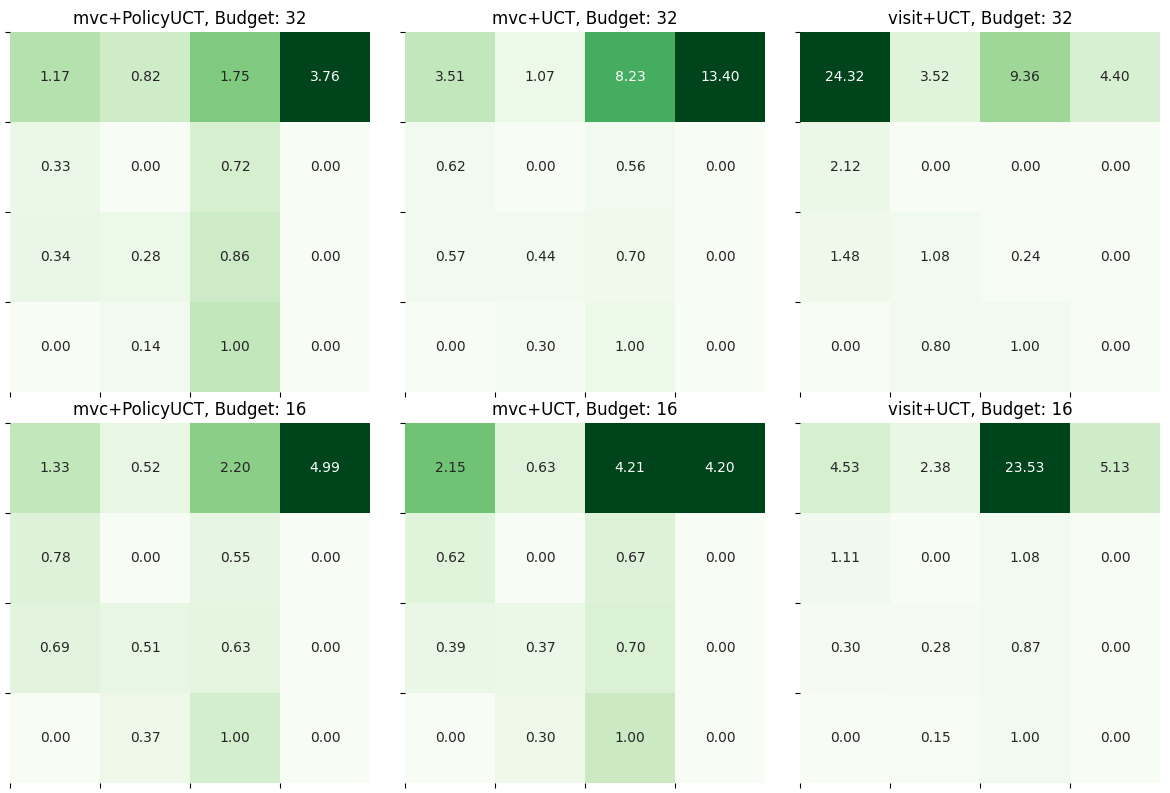

In [22]:
# Define functions to calculate coordinates and density
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(trajectories, ncols, nrows):
    density = np.zeros((nrows, ncols))
    for trajectory in trajectories:
        for state in trajectory:
            row, col = obs_to_cords(state, ncols)
            density[row, col] += 1
    return density

# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in filtered_aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs
    sns.heatmap(density, ax=ax, cmap='Greens', cbar=False, annot=True, fmt='.2f')
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square
    # set subtitle
    ax.set_title(f"{policy_combination}, Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/cliff_heurstic_density.pdf")
plt.show()


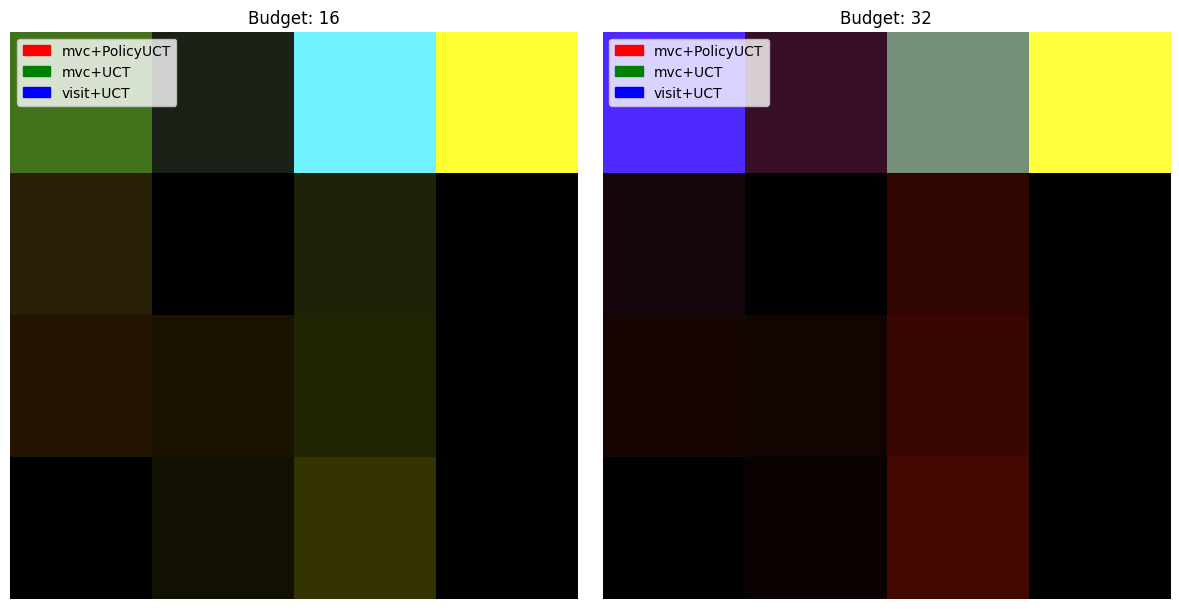

In [23]:
import matplotlib.patches as mpatches
grouped = df.groupby(['planning_budget', 'policy_combination'])['trajectories'].sum()


# Determine the number of unique planning budgets
n_budgets = len(grouped.index.get_level_values(0).unique())

# Prepare a single figure with multiple subplots (one for each planning_budget)
fig, axs = plt.subplots(1, n_budgets, figsize=(6 * n_budgets, 6))

# Iterate over each planning_budget and create RGB heatmaps
for idx, (planning_budget, budget_group) in enumerate(grouped.groupby(level=0)):
    rgb_image = np.zeros((nrows, ncols, 3))  # Initialize RGB layers
    colors = ['Red', 'Green', 'Blue']  # Map trajos keys to RGB channels
    channel_colors = {name: color for name, color in zip(budget_group.index.get_level_values(1), colors)}

    # Compute density for each policy combination and assign to RGB channels
    for jdx, ((_, policy_combination), trajectories) in enumerate(budget_group.items()):
        density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
        norm_density = density / np.max(density, where=(density!=0), initial=1)  # Normalize avoiding division by zero
        rgb_image[:, :, jdx % 3] += norm_density  # Accumulate in RGB layers, repeating colors if more than 3 policies

    ax = axs[idx] if n_budgets > 1 else axs
    ax.imshow(rgb_image, aspect='equal')
    ax.axis('off')  # Hide grid lines and labels

    # Create a legend
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in channel_colors.items()]
    ax.legend(handles=legend_patches, loc='upper left')
    ax.set_title(f"Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/dist_training_cliff_rgb.pdf")
plt.show()

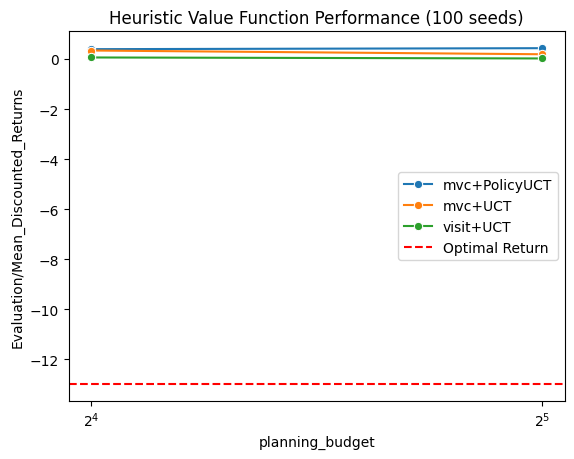

In [24]:
# plot Evaluation/Mean_Discounted_Returns from df vs planning_budget for each policy_combination

sns.lineplot(data=df, x='planning_budget', y='Evaluation/Mean_Discounted_Returns', hue='policy_combination', marker='o')
optimal_value = -13
plt.axhline(optimal_value, color='red', linestyle='--', label='Optimal Return')
# set x axis to log2 scale
plt.xscale('log', base=2)
plt.legend()
plt.title('Heuristic Value Function Performance (100 seeds)')
plt.savefig("outfiles/heuristic_value_function_performance.pdf")
plt.show()
